## CS3570 Introduction to Multimedia Technology
### Homework 02 Due: 11:59pm, 4/11/2025

#### In the first part:
You are required to implement DCT compression with different quality factors with the given image file (cat.jpg), and calculate the SSIM score of between the original image and compressed images.

Here's the step:
1. Convert the image from RGB to YCbCr following with chrominance subsampling 4:2:0.
2. Divide the Y, Cb, Cr channels into blocks of 8 x 8 pixels.
3. Shift values by -128 and transform the each 8x8 blocks from spatial domain to the DCT domain.
4. Apply quantization with the provided quantization tables and quality factor.
5. Reconstruct the image by taking inverse discrete cosine transform (IDCT) and shift values by +128.
6. Reassemble the Y, Cb, Cr channels from 8x8 blocks.
7. Upsample Cb, Cr and convert YCbCr back to RGB.
8. Compute the PSNR score with reconstructed images and the original image.

#### In the second part:
You need to design and apply different FIR filters into separate three audio signals from the given audio file (HW2_Mix.wav). Next, you are asked to reduce the sampling rate of filtered signals. Finally, since the output audio signals are too simple, you should apply one-fold echo and multiple-fold echo to produce more complex music.

Here's the step:
1. Transform the input signal into frequency domain and plot the spectrum (magnitude in spectrum should be normalized to [0, 1]).
2. Implement 3 different FIR filters to separate the three audio signals with Blackman window function (You have to pick the appropriate filter size, cut-off frequency, and window size).
3. Implement 1D convolution on the input signal with your filters (zero padding).
4. Reduce the sampling rates of the three separated songs to 2000Hz.
5. Apply one-fold echo and multiple-fold echo on the signal that pass through the **low-pass filter**. (Please use the audio files before reducing sampling rates)

### Reminder:
* **The imported libraries are sufficient for this homework, you are not permitted to import other Python packages.**
* **Your code must display and output your results to enable us to verify its correctness.**
* **Please follow the instructions in the Jupyter Notebook and complete the parts marked as `"TODO."`**
* **Please compress your Jupyter Notebook file, image results from Q1 and audio results from Q2 in a zip file named HW2_xxxxxxxxx_ooo.zip, where xxxxxxxxx is your student ID and ooo is your name.**
* **Homework should be submitted before the announced due time. Scores of late homework will be reduced by 20% per day.**
* **If you encounter any problems or have questions, please post them on eeclass.**

## Part 1: DCT compression (40%)

### Import the necessary libraries

In [23]:
# !pip install opencv-python numpy matplotlib scipy

import numpy as np
from cv2 import imread, imwrite
import matplotlib.pyplot as plt

### Define the quantization tables

In [49]:
# Quantization table for Y
QT_L = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 36, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Quantization table for Cb, Cr
QT_Chroma = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

### 1. Implement RGB to YCbCr and chrominance subsampling (4:2:0) (5%)

In [58]:
def RGB2YCbCr(img):
    '''
    Input:
        img: input image (RGB)
    Output:
        Y: Y channel
        Cb: Cb channel
        Cr: Cr channel
    '''
    H, W, _ = img.shape
    img_ycbcr = np.zeros(img.shape)
    Y = np.zeros((H, W))
    Cb = np.zeros((H//2, W//2))
    Cr = np.zeros((H//2, W//2))

    # matrices for calculating RGB to YCbCr
    M = np.array([[0.257, 0.564, 0.098],
                  [-0.148, -0.291, 0.439],
                  [0.439, -0.368, -0.071]])
    C = np.array([16, 128, 128])

    # [TODO]: Convert RGB to YCbCr with chrominance subsampling (4:2:0)
    for i in range(H):
        for j in range(W):
            rgb = img[i, j].astype(float)
            ycbcr = np.dot(M, rgb) + C
            Y[i, j] = ycbcr[0]
            img_ycbcr[i, j] = ycbcr
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            max_i = min(i + 2, H)
            max_j = min(j + 2, W)
            
            cb_sum = 0
            cr_sum = 0
            count = 0
            for bi in range(i, max_i):
                for bj in range(j, max_j):
                    cb_sum += img_ycbcr[bi, bj, 1]
                    cr_sum += img_ycbcr[bi, bj, 2]
                    count += 1
            Cb[i//2, j//2] = cb_sum / count
            Cr[i//2, j//2] = cr_sum / count
    return Y, Cb, Cr

### 2. Implement YCbCr to RGB (5%)

In [59]:
def YCbCr2RGB(Y, Cb, Cr):
    '''
    Input:
        Y: Y channel
        Cb: Cb channel
        Cr: Cr channel
    Output:
        img: output image (RGB)
    '''
    H, W = Y.shape
    # [TODO]: Upsample Cb and Cr
    Cb_upsample = np.repeat(np.repeat(Cb, 2, axis=0), 2, axis=1)[:H, :W]
    Cr_upsample = np.repeat(np.repeat(Cr, 2, axis=0), 2, axis=1)[:H, :W]
    img_YCbCr = np.stack((Y, Cb_upsample, Cr_upsample), axis=-1)
    img = np.zeros((H, W, 3))

    # matrices for converting YCbCr to RGB
    M = np.array([[1.164, 0, 1.596],
                  [1.164, -0.392, -0.813],
                  [1.164, 2.017, 0]])
    C = np.array([16, 128, 128])

    # [TODO]: Convert YCbCr back to RGB
    for i in range(H):
            for j in range(W):
                ycbcr = img_YCbCr[i, j].astype(float)
                rgb = np.dot(M, (ycbcr - C))
                img[i, j] = np.clip(rgb, 0, 255)
    return img

### 3. Implement Discrete Cosine Transform (DCT) (5%)

In [ ]:
def DCT(f):
    '''
    Input:
        f: image block
    Output:
        F: DCT transformed image block
    '''
    # [TODO]: Implement discrete cosine transform
    # Assuming f is an 8x8 block
    N = 8
    F = np.zeros((N, N))
    
    # DCT transformation
    for u in range(N):
        for v in range(N):
            cu = 1.0 / np.sqrt(2) if u == 0 else 1.0
            cv = 1.0 / np.sqrt(2) if v == 0 else 1.0
            
            sum_val = 0.0
            for x in range(N):
                for y in range(N):
                    sum_val += f[x, y] * np.cos((2*x+1)*u*np.pi/(2*N)) * np.cos((2*y+1)*v*np.pi/(2*N))
            
            F[u, v] = (2.0 / N) * cu * cv * sum_val
    return F

### 4. Implement Inverse Discrete Cosine Transform (IDCT) (5%)

In [ ]:
def IDCT(F):
    '''
    Input:
        F: DCT transformed image block
    Output:
        f: image block
    '''
    # [TODO]: Implement inverse discrete cosine transform
    # Assuming F is an 8x8 block
    N = 8
    f = np.zeros((N, N))
    
    # IDCT transformation
    for x in range(N):
        for y in range(N):
            sum_val = 0.0
            for u in range(N):
                for v in range(N):
                    cu = 1.0 / np.sqrt(2) if u == 0 else 1.0
                    cv = 1.0 / np.sqrt(2) if v == 0 else 1.0
                    
                    sum_val += cu * cv * F[u, v] * np.cos((2*x+1)*u*np.pi/(2*N)) * np.cos((2*y+1)*v*np.pi/(2*N))
            
            f[x, y] = (2.0 / N) * sum_val
    return f

### 5. Implement quantization with quality factor (5%)

In [ ]:
def quantize(img, Qf, chroma=True):
    '''
    Input:
        img: image block
        Qf: quality factor
    Output:
        img: quantized image block
    '''
    # [TODO]: Implement quantization
    if Qf < 50:
        S = 5000 / Qf
    else:
        S = 200 - 2*Qf
    
    if chroma:     
        T_s = np.floor(QT_Chroma * S / 100 + 0.5)
    else:         
        T_s = np.floor(QT_L * S / 100 + 0.5)
    
    T_s = np.maximum(T_s, 1)
    
    quantized = np.round(img / T_s)
    return quantized

### 6. DCT compression process (10%)

In [ ]:
def dct_compression(img, Qf):
    '''
    Input:
        img: input image
        Qf: quality factor
    Output:
        compressed: compressed image
    '''
    height, weight, _ = img.shape
    block_size = 8

    Y, Cb, Cr = RGB2YCbCr(img)
    Y_compressed = np.zeros(Y.shape)
    Cb_compressed = np.zeros(Cb.shape)
    Cr_compressed = np.zeros(Cr.shape)

    # [TODO]: Implement the DCT compression process

    # Process Y channel
    for i in range(0, height, block_size):
        for j in range(0, weight, block_size):
            i_end = min(i + block_size, height)
            j_end = min(j + block_size, weight)
            
            block = np.zeros((block_size, block_size))
            block[:i_end-i, :j_end-j] = Y[i:i_end, j:j_end]
            
            # Step 3: Shift values by -128 and apply DCT
            dct_block = DCT(block - 128)
            
            # Step 4: Apply quantization
            quantized = quantize(dct_block, Qf, chroma=False)
            
            # Step 5: Inverse DCT and shift by +128
            if Qf < 50:
                S = 5000 / Qf
            else:
                S = 200 - 2*Qf
            T_s = np.floor(QT_L * S / 100 + 0.5)
            T_s = np.maximum(T_s, 1)
            dequantized = quantized * T_s
            reconstructed = IDCT(dequantized) + 128
            
            Y_compressed[i:i_end, j:j_end] = reconstructed[:i_end-i, :j_end-j]

    # Process Cb, Cr channels
    cb_height, cb_width = Cb.shape
    for i in range(0, cb_height, block_size):
        for j in range(0, cb_width, block_size):
            i_end = min(i + block_size, cb_height)
            j_end = min(j + block_size, cb_width)
            
            # Process Cb channel
            cb_block = np.zeros((block_size, block_size))
            cb_block[:i_end-i, :j_end-j] = Cb[i:i_end, j:j_end]
            
            dct_cb = DCT(cb_block - 128)
            quantized_cb = quantize(dct_cb, Qf, chroma=True)
            if Qf < 50:
                S_cb = 5000 / Qf
            else:
                S_cb = 200 - 2*Qf
            T_s_cb = np.floor(QT_Chroma * S_cb / 100 + 0.5)
            T_s_cb = np.maximum(T_s_cb, 1)
            dequantized_cb = quantized_cb * T_s_cb
            reconstructed_cb = IDCT(dequantized_cb) + 128
            
            Cb_compressed[i:i_end, j:j_end] = reconstructed_cb[:i_end-i, :j_end-j]
            
            # Process Cr channel
            cr_block = np.zeros((block_size, block_size))
            cr_block[:i_end-i, :j_end-j] = Cr[i:i_end, j:j_end]
            
            dct_cr = DCT(cr_block - 128)
            quantized_cr = quantize(dct_cr, Qf, chroma=True)
            if Qf < 50:
                S_cr = 5000 / Qf
            else:
                S_cr = 200 - 2*Qf
            T_s_cr = np.floor(QT_Chroma * S_cr / 100 + 0.5)
            T_s_cr = np.maximum(T_s_cr, 1)
            dequantized_cr = quantized_cr * T_s_cr
            reconstructed_cr = IDCT(dequantized_cr) + 128
            
            Cr_compressed[i:i_end, j:j_end] = reconstructed_cr[:i_end-i, :j_end-j]
    
    # Step 7: Convert YCbCr back to RGB
    img_compressed = YCbCr2RGB(Y_compressed, Cb_compressed, Cr_compressed)

    return np.clip(img_compressed, 0, 255).astype(np.uint8)

### 7. Implement Peak Signal-to-Noise Ratio (PSNR) (5%)

In [ ]:
def PSNR(original, compressed):
    '''
    Input:
        original: original image
        compressed: compressed image
    Output:
        psnr: PSNR value
    '''
    # [TODO]: Calculate PSNR from the original image and the compressed image
    original = original.astype(np.float64)
    compressed = compressed.astype(np.float64)
    
    # mean squared error
    mse = np.mean((original - compressed) ** 2)
    
    if mse == 0:
        return float('inf')
    
    # PSNR = 10 * log10(MAX^2 / MSE)
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr

### Experiment with different quality factor

In [74]:
image = imread('Barbara.jpg')

Qf = 80
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

Qf = 30
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

Qf = 5
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

PSNR (Qf=80): 29.669984007131987
PSNR (Qf=30): 27.25752367069787
PSNR (Qf=5): 22.2303593470925


True

## Part 2: FIR Filter (40%)

In [2]:
from scipy.io import wavfile
from scipy.fft import fft, fftfreq

### 1. Plot the frequency spectrum (5%)

In [34]:
def plot_spectrum(data, title, fs, xbond, ybond):
    '''
    Input:
        data: input signal
        title: title of the plot
        fs: sampling frequency
        xbond: x-axis range
        ybond: y-axis range
    '''
    # TODO: FFT & Plot the magnitude spectrum of the input signal
    N = len(data)
    yf = fft(data)
    xf = fftfreq(N, 1/fs)[:N//2]
    
    magnitude = np.abs(yf[:N//2])
    
    # normalize magnitude to [0, 1]
    max_magnitude = np.max(magnitude)
    if max_magnitude > 0:
        magnitude_normalized = magnitude / max_magnitude
    else:
        magnitude_normalized = magnitude
    
    result = np.column_stack((xf, magnitude_normalized))
    plt.figure()
    plt.xlim(xbond[0], xbond[1])
    plt.ylim(ybond[0], ybond[1])
    plt.plot(result[:, 0], result[:, 1])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)

### 2. Implement three different filters - Lowpass, Highpass, Bandpass (10%)

In [35]:
def filter_generator(sample_rate, cutoff, filter_type, window_type, N):
    '''
    Input:
        sample_rate: sampling frequency
        cutoff: cutoff frequency
        filter_type: type of filter (Lowpass, Highpass, Bandpass)
        window_type: type of window function (Blackmann)
        N: filter length (number of points in a filter), also the window length
    Output:
        filter: low-pass, high-pass, or band-pass filter
    '''
    if filter_type == 'Lowpass' or filter_type == 'Highpass':
        cutoff = cutoff / sample_rate
    elif filter_type == 'Bandpass':
        cutoff = [cutoff[0] / sample_rate, cutoff[1] / sample_rate]
    else:
        raise ValueError('Invalid filter type')

    mid = N // 2
    n = np.arange(-mid, mid+1)
    n[mid] = 1
    filter = np.zeros(2 * mid + 1)

    if filter_type == 'Lowpass':
        # [TODO]: Implement the Low-pass filter
        for i in range(len(n)):
            if i == mid:  # n = 0
                filter[i] = 2 * cutoff
            else:
                filter[i] = np.sin(2 * np.pi * cutoff * n[i]) / (np.pi * n[i])
    elif filter_type == 'Highpass':
        # [TODO]: Implement the High-pass filter
        for i in range(len(n)):
            if i == mid:  # n = 0
                filter[i] = 1 - 2 * cutoff
            else:
                filter[i] = -np.sin(2 * np.pi * cutoff * n[i]) / (np.pi * n[i])
    elif filter_type == 'Bandpass':
        # [TODO]: Implement the Band-pass filter
        for i in range(len(n)):
            if i == mid:  # n = 0
                filter[i] = 2 * (cutoff[1] - cutoff[0])
            else:
                filter[i] = (np.sin(2 * np.pi * cutoff[1] * n[i]) - 
                            np.sin(2 * np.pi * cutoff[0] * n[i])) / (np.pi * n[i])

    n = np.arange(0, N)
    if window_type == "Blackmann":
        # [TODO]: Implement Blackmann window function
        # Implement Blackmann window function
        window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
        
        filter = filter * window

    return filter

In [36]:
def plot_filter(filter, title):

    plt.figure()
    plt.plot(filter)
    plt.title(title)
    plt.xlabel('samples')
    plt.ylabel('amplitude')
    plt.show()

### 3. Implement convolution function (10%)

In [37]:
def convolve(signal , filter , N):
    '''
    Input:
        signal: input signal
        filter: filter
        N: filter length
    Output:
        out: output signal
    '''
    len_signal = len(signal)
    out = np.zeros(len(signal))

    # [TODO]: Implement the 1D convolution operation
    for i in range(len_signal):
        for j in range(N):
            pos = i - j + N//2
            if 0 <= pos < len_signal:
                out[i] += signal[pos] * filter[j]
    return out

### 4. Reduce sample rate (5%)

In [38]:
def down_sampling(signal, fs, new_fs):
    '''
    Input:
        signal: input signal
        fs: sampling frequency
        new_fs: new sampling frequency
    Output:
        output_signal: down-sampled signal
    '''
    # [TODO]: Implement the down-sampling operation
    new_length = int(len(signal) * (new_fs / fs))
    
    downsampled_signal = np.zeros(new_length)
    ratio = len(signal) / new_length
    
    for i in range(new_length):
        exact_pos = i * ratio
        
        pos_floor = int(np.floor(exact_pos))
        pos_ceil = min(int(np.ceil(exact_pos)), len(signal) - 1)
        
        if pos_floor == pos_ceil:
            downsampled_signal[i] = signal[pos_floor]
        else:
            weight_ceil = exact_pos - pos_floor
            weight_floor = 1 - weight_ceil
            downsampled_signal[i] = weight_floor * signal[pos_floor] + weight_ceil * signal[pos_ceil]
            
    return downsampled_signal

### 5. Implement one-fold / multiple-fold echo (10%)

In [ ]:
def echo(signal_low, delay, alpha, fs):
    '''
    Input:
        signal_low: input signal (time-domain)
        delay: delay time
        alpha: attenuation factor
        fs: sampling frequency
    Output:
        output_echo_one: output signal with one-fold echo
        output_echo_multiple: output signal with multiple-fold echo
    '''

    D = int(delay * fs)
    input_len = len(signal_low)
    output_len = input_len + D
    #[TODO]: One-fold echo, multiple-fold echo
    # y[n] = x[n] + alpha*x[n-D]
    output_echo_one = np.zeros(output_len)
    output_echo_one[:input_len] = signal_low  
    output_echo_one[D:D+input_len] += alpha * signal_low 

    # Multiple-fold echo
    output_echo_multiple = np.zeros(output_len)
    
    for i in range(output_len):
        if i < input_len:
            output_echo_multiple[i] += signal_low[i]
        
        if i >= D:
            output_echo_multiple[i] += alpha * output_echo_multiple[i-D]
            
    return  output_echo_one, output_echo_multiple

### Note: There should be 10 images displayed below the cell.

/var/folders/6y/1p59drms6zgd5q4q25shp_gh0000gn/T/ipykernel_15977/2370751074.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('HW2_Mix.wav')


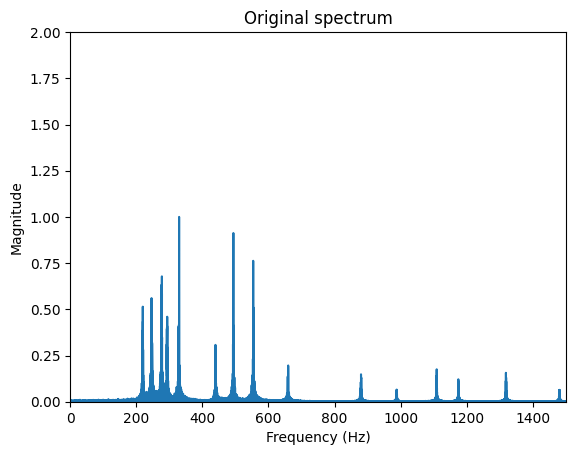

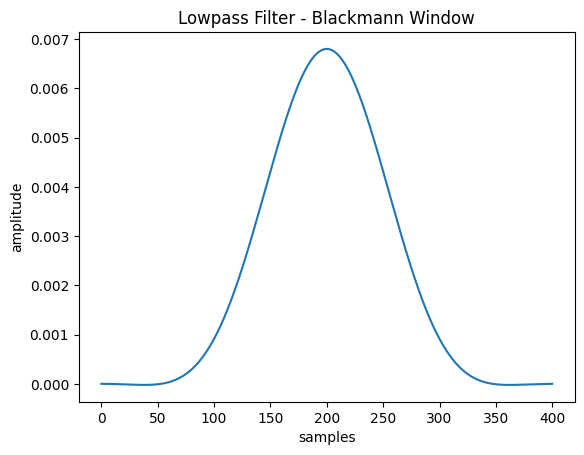

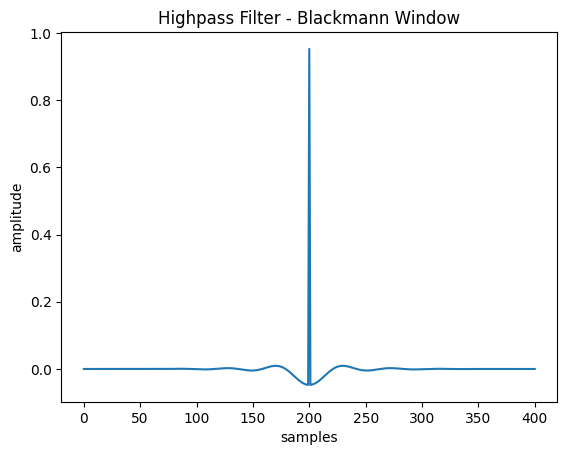

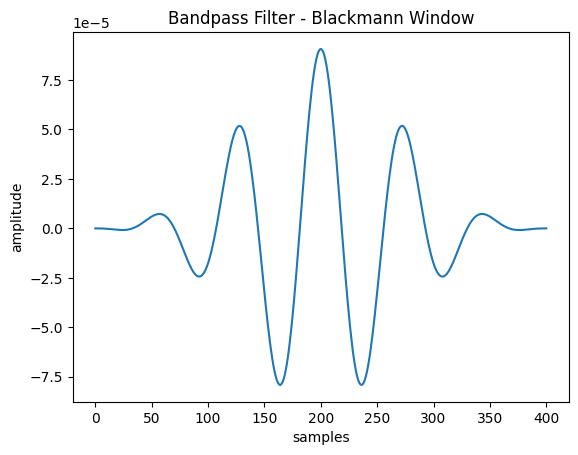

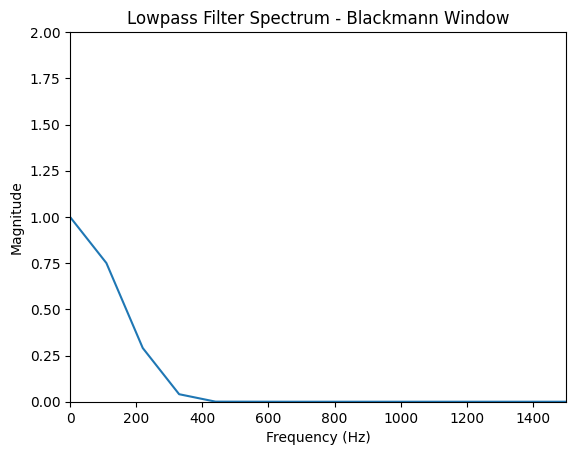

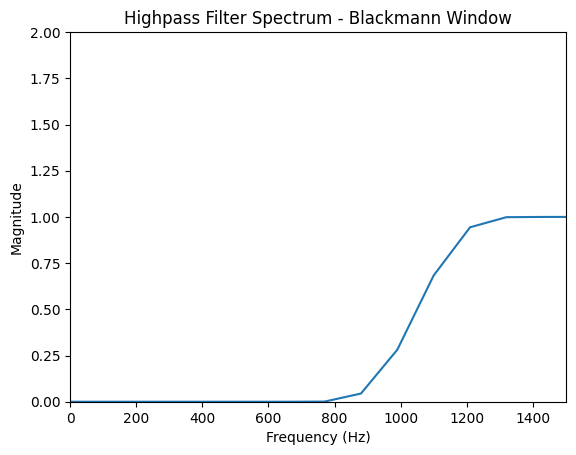

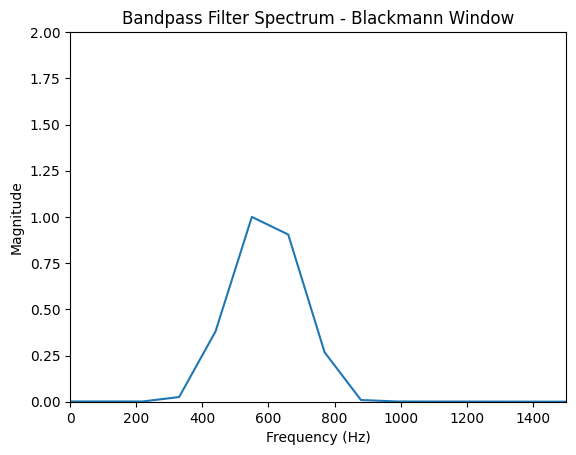

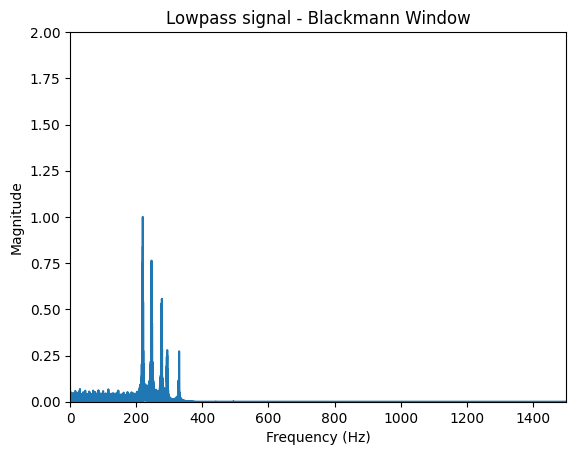

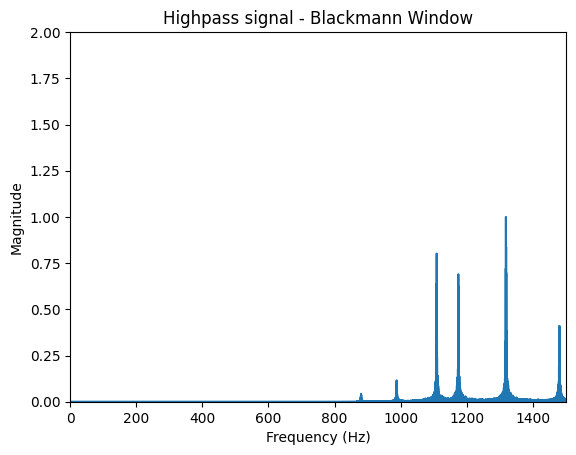

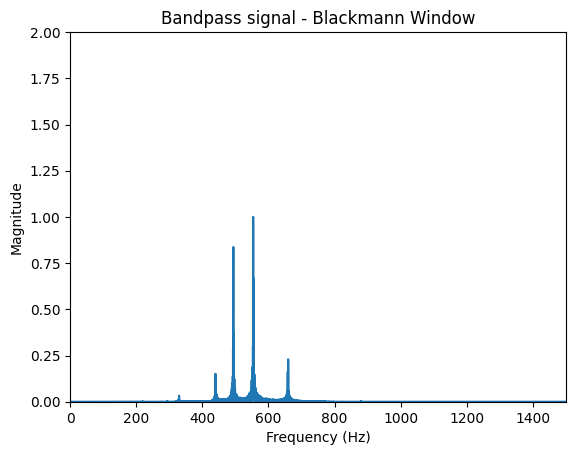

In [76]:
# Read the wav file
fs, data = wavfile.read('HW2_Mix.wav')

# Plot the magnitude spectrum of the input signal
plot_spectrum(data, "Original spectrum", fs, [0, 1500], [0, 2])

# [TODO]: determine the cutoff frequency and window size
fc_low = 150
fc_high = 1050
fc_band = np.array([593, 595])
filter_size = 401

# Generate filter with Blackmann window - Lowpass, Highpass, Bandpass
lowpass_blackmann_filter = filter_generator(fs, fc_low, 'Lowpass', 'Blackmann', filter_size)
highpass_blackmann_filter = filter_generator(fs, fc_high, 'Highpass', 'Blackmann', filter_size)
bandpass_blackmann_filter = filter_generator(fs, fc_band, 'Bandpass', 'Blackmann', filter_size)

# Plot filter shape
plot_filter(lowpass_blackmann_filter, "Lowpass Filter - Blackmann Window")
plot_filter(highpass_blackmann_filter, "Highpass Filter - Blackmann Window")
plot_filter(bandpass_blackmann_filter, "Bandpass Filter - Blackmann Window")

# Plot the magnitude spectrum of different filters
plot_spectrum(lowpass_blackmann_filter, "Lowpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(highpass_blackmann_filter, "Highpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(bandpass_blackmann_filter, "Bandpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])

# Convolve the input signal with different filters
signal_low = convolve(data, lowpass_blackmann_filter, filter_size)
signal_high = convolve(data, highpass_blackmann_filter, filter_size)
signal_band = convolve(data, bandpass_blackmann_filter, filter_size)
plot_spectrum(signal_low, "Lowpass signal - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(signal_high, "Highpass signal - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(signal_band, "Bandpass signal - Blackmann Window", fs, [0, 1500], [0, 2])

# save audio
wavfile.write(f"Low_pass_{fc_low}.wav", fs, signal_low)
wavfile.write(f"High_pass_{fc_high}.wav", fs, signal_high)
wavfile.write(f"Band_pass_{fc_band[0]}_{fc_band[1]}.wav", fs, signal_band)

# Reduce sample rate
new_fs = 2000
signal_low_ds = down_sampling(signal_low, fs, new_fs)
signal_high_ds = down_sampling(signal_high, fs, new_fs)
signal_band_ds = down_sampling(signal_band, fs, new_fs)

# You can also try setting 'new_fs' as 'fs' to see what happens.
wavfile.write(f"Low_pass_{fc_low}_2khz.wav", new_fs, signal_low_ds)
wavfile.write(f"High_pass_{fc_high}_2khz.wav", new_fs, signal_high_ds)
wavfile.write(f"Band_pass_{fc_band[0]}_{fc_band[1]}_2khz.wav", new_fs, signal_band_ds)

# Generate echo
echo_one , echo_multiple = echo(signal_low, 1, 0.5, fs)
wavfile.write('Echo_one.wav', fs, echo_one)
wavfile.write("Echo_multiple.wav", fs, echo_multiple)

## Report (20%)

Your report should cover the following aspects:
* DCT compression
    * Describe how you implemented the discrete cosine transform. (4%)
        * First shift pixel values by -128
        * Apply DCT to obtain frequency domain representation
        * Apply IDCT to reconstruct the spatial domain representation
        * Shift values back by +128
    * Why should we convert image from RGB to YCbCr before compressing? (3%)
        * The YCbCr format is more easily for us to implement chrominance subsampling. Since RGB are highly correlated, when brightness changes, all channels have to change. But with YCbCr, we can stores color information at lower resolution independently. This give a big benfits to calculate faster, making the process more effective.
        * The quantizations tables can be optimized separately for luminance and chrominance.
    * Explain how can the quality factor affects the compression result. (3%)
        * QF determines how the quantization tables are scaled, lower QF bring higher scale, results in more aggressive quantization.
        * For Higher QF
            * less aggressive quantization -> more DCT coefficients are preserved -> better image quality, larger file sizes, higher PSNR values.
        * For Lower QF
            * more aggressive quantization -> more DCT coefficients are reduces to zero -> more high-frequency information is discarded -> more blocking, degradation of image, smaller file sizes, lower PSNR values.
* FIR Filter
    * Describe how you implemented the filter and convolutions to separate tha mixed song. And how did you determine the filter size and cut-off frequency. (4%)
        * For implementation of the filter, use different formula for different type of filter, and then deal with special cast n = 0, finally multiple the Blackman window.
            * LowPass filter
            ```
                if i == mid:  # n = 0
                    filter[i] = 2 * cutoff
                else:
                    filter[i] = np.sin(2 * np.pi * cutoff * n[i]) / (np.pi * n[i])
            ```
            * HighPass filter
            ```
                if i == mid:  # n = 0
                    filter[i] = 1 - 2 * cutoff
                else:
                    filter[i] = -np.sin(2 * np.pi * cutoff * n[i]) / (np.pi * n[i])
            ```
            * BandPass filter
            ```
                if i == mid:  # n = 0
                    filter[i] = 2 * (cutoff[1] - cutoff[0])
                else:
                    filter[i] = (np.sin(2 * np.pi * cutoff[1] * n[i]) - 
                                np.sin(2 * np.pi * cutoff[0] * n[i])) / (np.pi * n[i])
            ```
        * For convolution, implemented a 1D operation that centers the filter kerna; around each input signal position, applies zero-padding at the boundaries, multiplies the filter coefficients with the corresponding signal values.
        * For choosing the Filter parameters
            * Filter size
                * Through try and error, find a good balanve between efficiency and how sharp the frequency is.
            * low frequency
                * first see the original spectrum, we can see that the lower frequency are below 300, so start from 300, and do multiple tries. Choose the value that only the frequencirs that are low enough remain.
            * high frequency
                * see the original spectrum, we can tell that the higher frequency are higher thatn 800, so start from 800 and do serveral tries. Choose the value that only the frequencies that are high enough remain.
            * bandpass frequency
                * see the original spectrum, we can tell that the middle frequency is around 600, so choose 500 to 600 first, then shrink the interval time by time.
    * Compare the spectrum and shape of the filters. (3%)
        * Filter shapes : difference occurs based on their formula.
            * Central peak value
                * low : 2*cutoff
                * high : 1-2*cutoff
                * band : 2*(cutoff[1]-cutoff[0])
            * waveform
                * low : like a sin function ,symmetric with slowly decaying amplitude.
                * high : Inverted sinc pattern, more pronounced positive/negative alternation.
                * band : sinc-like signal, with more oscillations and a slowly decaying envelope.
            * Overall : Lowpass is the smoothest and most concentrated; highpass has more rapid sign changes; bandpass is the most complex but highly selective.
        * Spectrum of the Filters
            * Passband Range
                * low : low frequencies (0–150Hz), suppresses high frequencies. We can see the low pass signal concentrated at left of the graph.
                * high : Suppresses low frequencies, passes high frequencies (above 1050Hz). We can see the high pass signal concentrated at right of the graph.
                * band : Only passes a very narrow range (593–595Hz); most frequencies are attenuated. But in fact, we can see there are still frequencies that near this range pass the bandpass filter.
            * Transition Band Width
                * All three filters use the Blackman window, resulting in a relatively wide but smooth transition band.
                * Bandpass has the sharpest transition due to its extremely narrow bandwidth.
    * Compare the difference between the signals before and after reducing the sampling rates. (3%)
        * Since we sampleing the signals to 2000Hz, the new Nyquist frequency become 1000Hz. Therefore, signals that its main frequency above 1000Hz may have more loss.
        * for Lowpass filter, the frequencies mainly below 150Hz which is well above the main signal range, has the minimal loss of audio quality.
        * For Highpass Filter, Contains high frequencies above 1050Hz which is below the main content, making the aliasing occurs, has a significant audio degradation.
        * For Bandpass Filter centered in the narrow band 593–595Hz, its main frequency range preserved, but with reduced resolution, having moderate quality retention and less detail.
        * Overall impact
            * Resolution decreases, Signal length shrinks, details become blurry are Inevitable.